# predicting coronal mass ejections using machine learning methods

A Coronal Mass Ejection (CME) throws magnetic flux and plasma from the Sun into interplanetary space. They are closely related to solar flares and the larger the flare the more likely a CME will form. A CME can cause damage to the electric grid and can interfere with radio signals due to geomagnetic storms.

1. The positive class contains flaring active regions that did produce a CME. 
2. The negative class contains flaring active regions that did not produce a CME. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import json
from datetime import datetime as dt_obj
from datetime import timedelta
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sunpy.time import TimeRange
import sunpy.instr.goes
import lime
import lime.lime_tabular
pd.set_option('display.max_rows', 500)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### step 1: gathering data for the positive class

1. CME data from [DONKI database](http://kauai.ccmc.gsfc.nasa.gov/DONKI/). Can find if an active region has produced a CME or not.

In [3]:
# request the data
baseurl = "https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?"
t_start = "2010-05-01"
t_end = "2018-04-01"
url = baseurl+"startDate="+t_start+"&endDate="+t_end

# if there's no response at this time, print warning
response = requests.get(url)
if response.status_code != 200:
    print('cannot successfully get an http response')

In [4]:
# read the data

print("Getting data from", url)
df = pd.read_json(url)

# select flares associated with a linked event (SEP or CME), and
# select only M or X-class flares
events_list = df.loc[df['classType'].str.contains(
    "M|X") & ~df['linkedEvents'].isnull()]

# drop all rows that don't satisfy the above conditions
events_list = events_list.reset_index(drop=True)

Getting data from https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?startDate=2010-05-01&endDate=2018-04-01


In [5]:
# drop the rows that aren't linked to CME events
for i in range(events_list.shape[0]):
    value = events_list.loc[i]['linkedEvents'][0]['activityID']
    if not "CME" in value:
        print(value, "not a CME, dropping row")
        events_list = events_list.drop([i])
events_list = events_list.reset_index(drop=True)

2011-08-09T08:40:00-SEP-001 not a CME, dropping row
2011-09-07T06:00:00-SEP-001 not a CME, dropping row
2011-09-24T11:50:00-SEP-001 not a CME, dropping row
2011-09-24T20:45:00-SEP-001 not a CME, dropping row
2012-07-09T01:20:00-SEP-001 not a CME, dropping row
2013-06-21T06:09:00-SEP-001 not a CME, dropping row
2015-03-06T19:20:00-SEP-001 not a CME, dropping row
2015-06-18T09:25:00-SEP-001 not a CME, dropping row
2015-06-21T20:35:00-SEP-001 not a CME, dropping row
2015-06-21T20:35:00-SEP-001 not a CME, dropping row


Convert the `peakTime` column in the `events_list` dataframe from a string into a datetime object:

In [6]:
def parse_tai_string(tstr):
    year = int(tstr[:4])
    month = int(tstr[5:7])
    day = int(tstr[8:10])
    hour = int(tstr[11:13])
    minute = int(tstr[14:16])
    return dt_obj(year, month, day, hour, minute)


for i in range(events_list.shape[0]):
    events_list['peakTime'].iloc[i] = parse_tai_string(
        events_list['peakTime'].iloc[i])

Check if CME and flare exist but NOAA active region number does not exist in the DONKI database.

In [ ]:
number_of_donki_mistakes = 0  # count the number of DONKI mistakes
# create an empty array to hold row numbers to drop at the end
event_list_drops = []

for i in range(events_list.shape[0]):
    if (np.isnan(events_list.loc[i]['activeRegionNum'])):
        time = events_list['peakTime'].iloc[i]
        time_range = TimeRange(time, time)
        listofresults = sunpy.instr.goes.get_goes_event_list(time_range, 'M1')
        if (listofresults[0]['noaa_active_region'] == 0):
            print(events_list.loc[i]['activeRegionNum'], events_list.loc[i]
                  ['classType'], "has no match in the GOES flare database ; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1
            continue
        else:
            print("Missing NOAA number:", events_list['activeRegionNum'].iloc[i], events_list['classType'].iloc[i],
                  events_list['peakTime'].iloc[i], "should be", listofresults[0]['noaa_active_region'], "; changing now.")
            events_list['activeRegionNum'].iloc[i] = listofresults[0]['noaa_active_region']
            number_of_donki_mistakes += 1

# Drop the rows for which there is no active region number in both the DONKI and GOES flare databases
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Now we grab all the data from the GOES database in preparation for checking Cases 2 and 3.

In [8]:
# Grab all the data from the GOES database
time_range = TimeRange(t_start, t_end)
listofresults = sunpy.instr.goes.get_goes_event_list(time_range, 'M1')
print('Grabbed all the GOES data; there are', len(listofresults), 'events.')

Grabbed all the GOES data; there are 793 events.


Check if the NOAA active region number is wrong in the DONKI database.

In [9]:
# collect all the peak flares times in the NOAA database
peak_times_noaa = [item["peak_time"] for item in listofresults]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    if peak_time_donki in peak_times_noaa:
        index = peak_times_noaa.index(peak_time_donki)
    else:
        continue
    # ignore NOAA active region numbers equal to zero
    if (listofresults[index]['noaa_active_region'] == 0):
        continue
    # if yes, check if the DONKI and NOAA active region numbers match up for this peak time
    # if they don't, flag this peak time and replace the DONKI number with the NOAA number
    if (listofresults[index]['noaa_active_region'] != int(events_list['activeRegionNum'].iloc[i])):
        print('Messed up NOAA number:', int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
              events_list['peakTime'].iloc[i], "should be", listofresults[index]['noaa_active_region'], "; changing now.")
        events_list['activeRegionNum'].iloc[i] = listofresults[index]['noaa_active_region']
        number_of_donki_mistakes += 1
print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Messed up NOAA number: 11943 X1.2 2014-01-07 18:32:00 should be 11944 ; changing now.
Messed up NOAA number: 12051 M1.2 2014-05-07 16:29:00 should be 12055 ; changing now.
Messed up NOAA number: 12160 M1.4 2014-07-01 11:23:00 should be 12106 ; changing now.
Messed up NOAA number: 12282 M2.4 2015-02-09 23:35:00 should be 12280 ; changing now.
There are 27 DONKI mistakes so far.


check if the flare peak time is wrong in the DONKI database.

In [ ]:
# create an empty array to hold row numbers to drop at the end
event_list_drops = []

active_region_numbers_noaa = [item["noaa_active_region"]
                              for item in listofresults]
flare_classes_noaa = [item["goes_class"] for item in listofresults]

for i in range(events_list.shape[0]):
    # check if a particular DONKI flare peak time is also in the NOAA database
    peak_time_donki = events_list['peakTime'].iloc[i]
    if not peak_time_donki in peak_times_noaa:
        active_region_number_donki = int(
            events_list['activeRegionNum'].iloc[i])
        flare_class_donki = events_list['classType'].iloc[i]
        flare_class_indices = [i for i, x in enumerate(
            flare_classes_noaa) if x == flare_class_donki]
        active_region_indices = [i for i, x in enumerate(
            active_region_numbers_noaa) if x == active_region_number_donki]
        common_indices = list(
            set(flare_class_indices).intersection(active_region_indices))
        if common_indices:
            print("Messed up time:", int(events_list['activeRegionNum'].iloc[i]), events_list['classType'].iloc[i],
                  events_list['peakTime'].iloc[i], "should be", peak_times_noaa[common_indices[0]], "; changing now.")
            events_list['peakTime'].iloc[i] = peak_times_noaa[common_indices[0]]
            number_of_donki_mistakes += 1
        if not common_indices:
            print("DONKI flare peak time",
                  events_list['peakTime'].iloc[i], "has no match; dropping row.")
            event_list_drops.append(i)
            number_of_donki_mistakes += 1

# Drop the rows for which the NOAA active region number and flare class associated with
# the messed-up flare peak time in the DONKI database has no match in the GOES flare database
events_list = events_list.drop(event_list_drops)
events_list = events_list.reset_index(drop=True)

# Create a list of corrected flare peak times
peak_times_donki = [events_list['peakTime'].iloc[i]
                    for i in range(events_list.shape[0])]

print('There are', number_of_donki_mistakes, 'DONKI mistakes so far.')

Positive class

In [ ]:
events_list

Query the JSOC database to see if there are active region parameters at the time of the flare. 

In [12]:
answer = pd.read_csv(
    'http://jsoc.stanford.edu/doc/data/hmi/harpnum_to_noaa/all_harps_with_noaa_ars.txt', sep=' ')

Predict 24 hours in advance

In [13]:
timedelayvariable = 24

In [14]:
t_rec = [(events_list['peakTime'].iloc[i] - timedelta(hours=timedelayvariable)
          ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(events_list.shape[0])]

Now we can grab the SDO data from the JSOC database by executing the JSON queries. We are selecting data that satisfies several criteria: The data has to be [1] disambiguated with a version of the disambiguation module greater than 1.1, [2] taken while the orbital velocity of the spacecraft is less than 3500 m/s, [3] of a high quality, and [4] within 70 degrees of central meridian. If the data pass all these tests, they are stuffed into one of two lists: one for the positive class (called CME_data) and one for the negative class (called no_CME_data).

In [15]:
def get_the_jsoc_data(event_count, t_rec):
    """
    Parameters
    ----------
    event_count: number of events 
                 int

    t_rec:       list of times, one associated with each event in event_count
                 list of strings in JSOC format ('%Y.%m.%d_%H:%M_TAI')

    """

    catalog_data = []
    classification = []

    for i in range(event_count):

        print("=====", i, "=====")
        # next match NOAA_ARS to HARPNUM
        idx = answer[answer['NOAA_ARS'].str.contains(
            str(int(listofactiveregions[i])))]

        # if there's no HARPNUM, quit
        if (idx.empty == True):
            print('skip: there are no matching HARPNUMs for',
                  str(int(listofactiveregions[i])))
            continue

        # construct jsoc_info queries and query jsoc database; we are querying for 25 keywords
        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (CODEVER7 !~ '1.1 ') and (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,MEANJZD,TOTUSJZ,SAVNCPP,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: cannot successfully get an http response')
            continue

        # read the JSON output
        data = response.json()

        # if there are no data at this time, quit
        if data['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # check to see if the active region is too close to the limb
        # we can compute the latitude of an active region in stonyhurst coordinates as follows:
        # latitude_stonyhurst = CRVAL1 - CRLN_OBS
        # for this we have to query the CEA series (but above we queried the other series as the CEA series does not have CODEVER5 in it)

        url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_cea_720s["+str(
            idx.HARPNUM.values[0])+"]["+t_rec[i]+"][? (abs(OBS_VR)< 3500) and (QUALITY<65536) ?]&op=rs_list&key=CRVAL1,CRLN_OBS"
        response = requests.get(url)

        # if there's no response at this time, quit
        if response.status_code != 200:
            print('skip: failed to find CEA JSOC data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        # read the JSON output
        latitude_information = response.json()

        # if there are no data at this time, quit
        if latitude_information['count'] == 0:
            print('skip: there are no data for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        CRVAL1 = float(latitude_information['keywords'][0]['values'][0])
        CRLN_OBS = float(latitude_information['keywords'][1]['values'][0])
        if (np.absolute(CRVAL1 - CRLN_OBS) > 70.0):
            print('skip: latitude is out of range for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        if ('MISSING' in str(data['keywords'])):
            print('skip: there are some missing keywords for HARPNUM',
                  idx.HARPNUM.values[0], 'at time', t_rec[i])
            continue

        print('accept NOAA Active Region number', str(int(
            listofactiveregions[i])), 'and HARPNUM', idx.HARPNUM.values[0], 'at time', t_rec[i])

        individual_flare_data = []
        for j in range(18):
            individual_flare_data.append(
                float(data['keywords'][j]['values'][0]))

        catalog_data.append(list(individual_flare_data))

        single_class_instance = [idx.HARPNUM.values[0], str(
            int(listofactiveregions[i])), listofgoesclasses[i], t_rec[i]]
        classification.append(single_class_instance)

    return catalog_data, classification

In [16]:
listofactiveregions = list(events_list['activeRegionNum'].values.flatten())
listofgoesclasses = list(events_list['classType'].values.flatten())

In [ ]:
positive_result = get_the_jsoc_data(events_list.shape[0], t_rec)

In [18]:
CME_data = positive_result[0]
positive_class = positive_result[1]
print("There are", len(CME_data), "CME events in the positive class.")

There are 77 CME events in the positive class.


### gathering data for the negative class

To gather the examples for the negative class, we only need to:

1. Query the GOES database for all the M- and X-class flares during our time of interest, and
2. Select the ones that are not associated with a CME. 

In [19]:
# select peak times that belong to both classes
all_peak_times = np.array([(listofresults[i]['peak_time'])
                           for i in range(len(listofresults))])

negative_class_possibilities = []
counter_positive = 0
counter_negative = 0
for i in range(len(listofresults)):
    this_peak_time = all_peak_times[i]
    if (this_peak_time in peak_times_donki):
        counter_positive += 1
    else:
        counter_negative += 1
        this_instance = [listofresults[i]['noaa_active_region'],
                         listofresults[i]['goes_class'], listofresults[i]['peak_time']]
        negative_class_possibilities.append(this_instance)
print("There are", counter_positive, "events in the positive class.")
print("There are", counter_negative, "events in the negative class.")

There are 138 events in the positive class.
There are 655 events in the negative class.


In [20]:
t_rec = np.array([(negative_class_possibilities[i][2] - timedelta(hours=timedelayvariable)
                   ).strftime('%Y.%m.%d_%H:%M_TAI') for i in range(len(negative_class_possibilities))])

And again, we query the JSOC database to see if these data are present:

In [21]:
listofactiveregions = list(
    negative_class_possibilities[i][0] for i in range(counter_negative))
listofgoesclasses = list(
    negative_class_possibilities[i][1] for i in range(counter_negative))

In [ ]:
negative_result = get_the_jsoc_data(counter_negative, t_rec)

In [23]:
no_CME_data = negative_result[0]
negative_class = negative_result[1]
print("There are", len(no_CME_data), "no-CME events in the negative class.")

There are 430 no-CME events in the negative class.


### feature selection

Normalize

In [24]:
CME_data = np.array(CME_data)
no_CME_data = np.array(no_CME_data)

In [25]:
def normalize_the_data(flare_data):
    flare_data = np.array(flare_data)
    n_elements = flare_data.shape[0]
    for j in range(flare_data.shape[1]):
        standard_deviation_of_this_feature = np.std(flare_data[:, j])
        median_of_this_feature = np.median(flare_data[:, j])
        for i in range(n_elements):
            flare_data[i, j] = (
                flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return flare_data


no_CME_data = normalize_the_data(no_CME_data)
CME_data = normalize_the_data(CME_data)

print("There are", no_CME_data.shape[0], "flares with no associated CMEs.")
print("There are", CME_data.shape[0], "flares with associated CMEs.")

There are 430 flares with no associated CMEs.
There are 77 flares with associated CMEs.


Let's look at the distribution of one feature for the active regions that both flared and produced a CME (green) and for the active regions that flared but did not produce a CME (red). You can change the value of `i` in the code block below to see that some features are totally useless as there is barely any difference in the distributions for the positive and negative class. As such, we can throw such features out of our sample. It's a good idea to do some feature selection before running the SVM, so as to reduce noise (in this case, with only 18 features, there's not too much noise to begin with). 

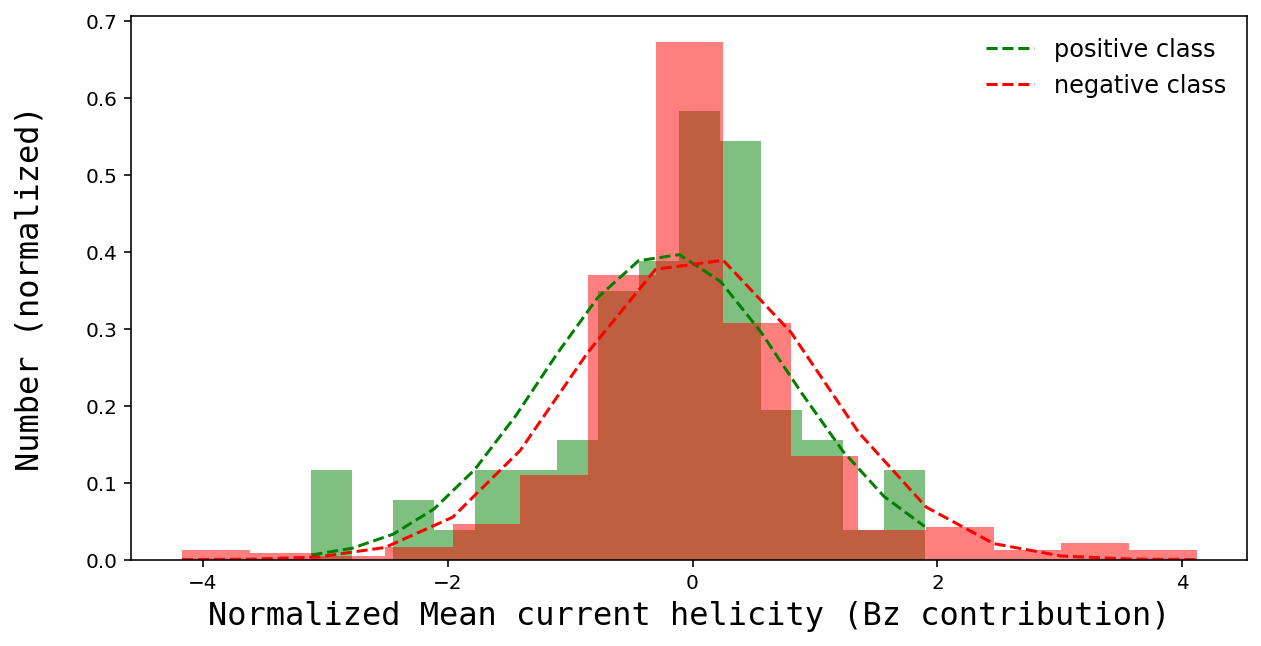

In [26]:
sharps = ['Total unsigned flux', 'Mean gradient of total field',
          'Mean current helicity (Bz contribution)', 'Mean photospheric magnetic free energy',
          'Fraction of Area with Shear > 45 deg', 'Total unsigned current helicity',
          'Mean gradient of horizontal field', 'Mean characteristic twist parameter, alpha',
          'Mean angle of field from radial', 'Mean gradient of vertical field',
          'Mean vertical current density', 'Total unsigned vertical current',
          'Sum of the modulus of the net current per polarity',
          'Total photospheric magnetic free energy density', 'Mean shear angle',
          'Area of strong field pixels in the active region', 'Sum of flux near polarity inversion line',
          'Absolute value of the net current helicity']

i = 2

# For the positive class (green)
mu_fl = np.mean(CME_data[:, i])
sigma_fl = np.std(CME_data[:, i])
num_bins = 15
n_fl, bins_fl, patches_fl = plt.hist(
    CME_data[:, i], num_bins, normed=1, facecolor='green', alpha=0.5)
y_fl = scipy.stats.norm.pdf(bins_fl, mu_fl, sigma_fl)
plt.plot(bins_fl, y_fl, 'g--', label='positive class')

# For the negative class (red)
mu_nofl = np.mean(no_CME_data[:, i])
sigma_nofl = np.std(no_CME_data[:, i])
n_nofl, bins_nofl, patches_nofl = plt.hist(
    no_CME_data[:, i], num_bins, normed=1, facecolor='red', alpha=0.5)
y_nofl = scipy.stats.norm.pdf(bins_nofl, mu_nofl, sigma_nofl)
plt.plot(bins_nofl, y_nofl, 'r--', label='negative class')

text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
plt.xlabel('Normalized '+sharps[i], **text_style)
plt.ylabel('Number (normalized)', labelpad=20, **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.savefig('fscore_tmp.png', bbox_inches='tight')
legend = plt.legend(loc='upper right', fontsize=12, framealpha=0.0, title='')
legend.get_frame().set_linewidth(0.0)

Compute F Score for feature selection

In [27]:
# import the feature selection method
from sklearn.feature_selection import SelectKBest, f_classif
# select the number of features
N_features = 18
Nfl = CME_data.shape[0]
Nnofl = no_CME_data.shape[0]
yfl = np.ones(Nfl)
ynofl = np.zeros(Nnofl)
# k is the number of features
selector = SelectKBest(f_classif, k=N_features)
selector.fit(np.concatenate((CME_data, no_CME_data), axis=0),
             np.concatenate((yfl, ynofl), axis=0))
scores = selector.scores_
print(scores)

[0.23129349 1.66767301 3.85850986 2.26629803 0.05521982 0.02133073
 0.97811712 2.89386483 0.40696658 0.00615498 0.6648416  0.05306211
 0.20062115 0.04774681 0.33766216 0.06349227 1.18890519 0.00428464]


It's not easy to interpret the scores in this fashion, so let's plot the results. The higher the Univariate Fisher Score, the more predictive the feature.

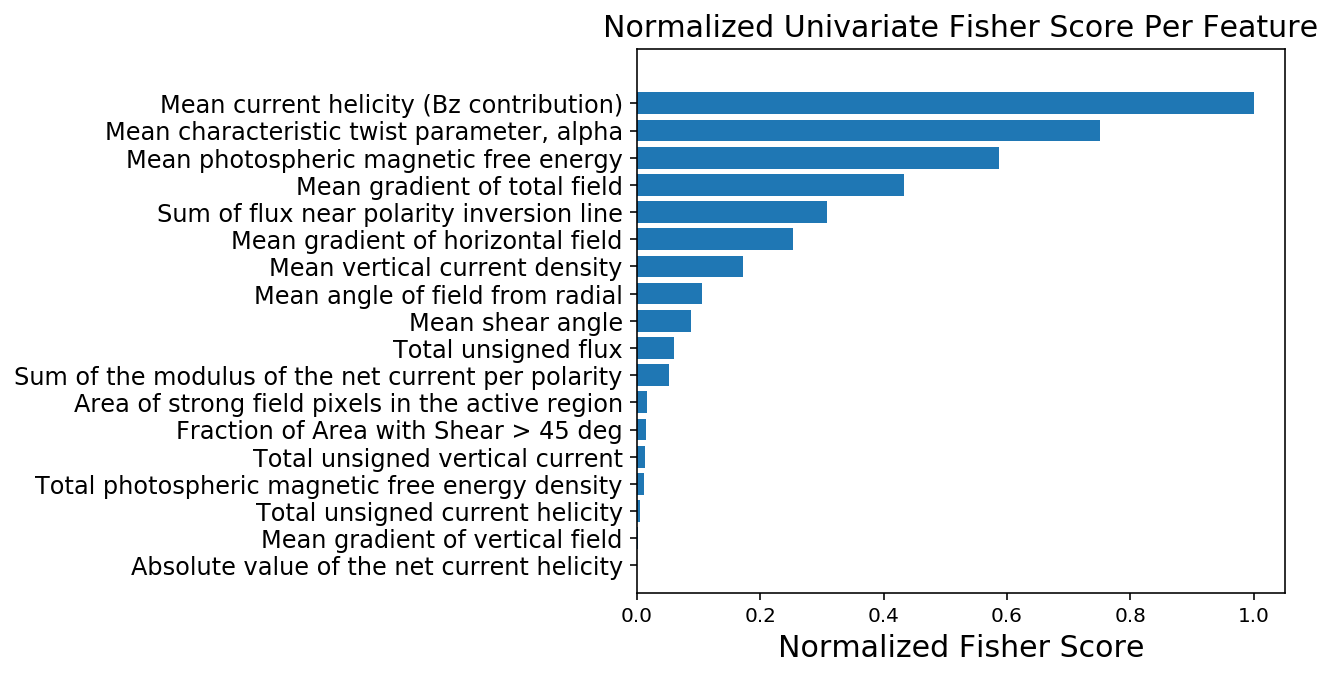

In [28]:
plt.clf()
order = np.argsort(scores)
orderedsharps = [sharps[i] for i in order]
y_pos2 = np.arange(18)
plt.barh(y_pos2, sorted(scores/np.max(scores)))
plt.ylim((-1, 19))
plt.yticks(y_pos2, orderedsharps, fontsize=12)
plt.xlabel('Normalized Fisher Score', fontsize=15)
plt.title('Normalized Univariate Fisher Score Per Feature', fontsize=15)
plt.subplots_adjust(left=0.5, right=1.0)
fig = plt.gcf()
fig.set_size_inches(9, 5)
plt.show()

### the support vector machine

In [29]:
number_of_examples = Nfl + Nnofl
C = 4.0
gamma = 0.075
class_weight = {1: 6.5}
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight,
              cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

### step 5: stratified k-folds cross-validation

Confusion Table to find TP, TN, FP, FN

In [30]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

Find a valid K. Recommended value is 10.

In [31]:
# lists to hold the TSS and standard deviation of the TSS
array_of_avg_TSS = np.ndarray([50])
array_of_std_TSS = np.ndarray([50])

# xdata are the examples
# ydata are the labels
xdata = np.concatenate((CME_data, no_CME_data), axis=0)
ydata = np.concatenate((np.ones(Nfl), np.zeros(Nnofl)), axis=0)

# mdata contain metadata about the active region that will be useful
# when we interpret the results using LIME
mdata = np.concatenate((positive_class, negative_class), axis=0)

# compute the TSS for a variety of k ranging from 2 to 52
# this is to see how the TSS varies as a function of k, and to test if k=10 really makes sense
for k in range(2, 52):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    these_TSS_for_this_k = []
    for train_index, test_index in skf.split(xdata, ydata):
        # xtrain are the examples in the training set
        xtrain = xdata[train_index]
        # ytrain are the labels in the training set
        ytrain = ydata[train_index]
        # xtest are the examples in the testing set
        xtest = xdata[test_index]
        ytest = ydata[test_index]    # ytest are the labels in the testing set
        
        clf.fit(xtrain, ytrain)
        TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
        if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
            these_TSS_for_this_k.append(np.nan)
            continue
        else:
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
    TSS_k = np.array(these_TSS_for_this_k)
    array_of_avg_TSS[k-2] = np.mean(TSS_k)
    array_of_std_TSS[k-2] = np.std(TSS_k)

Plot the mean TSS per k, using the standard deviation as the error in the TSS.

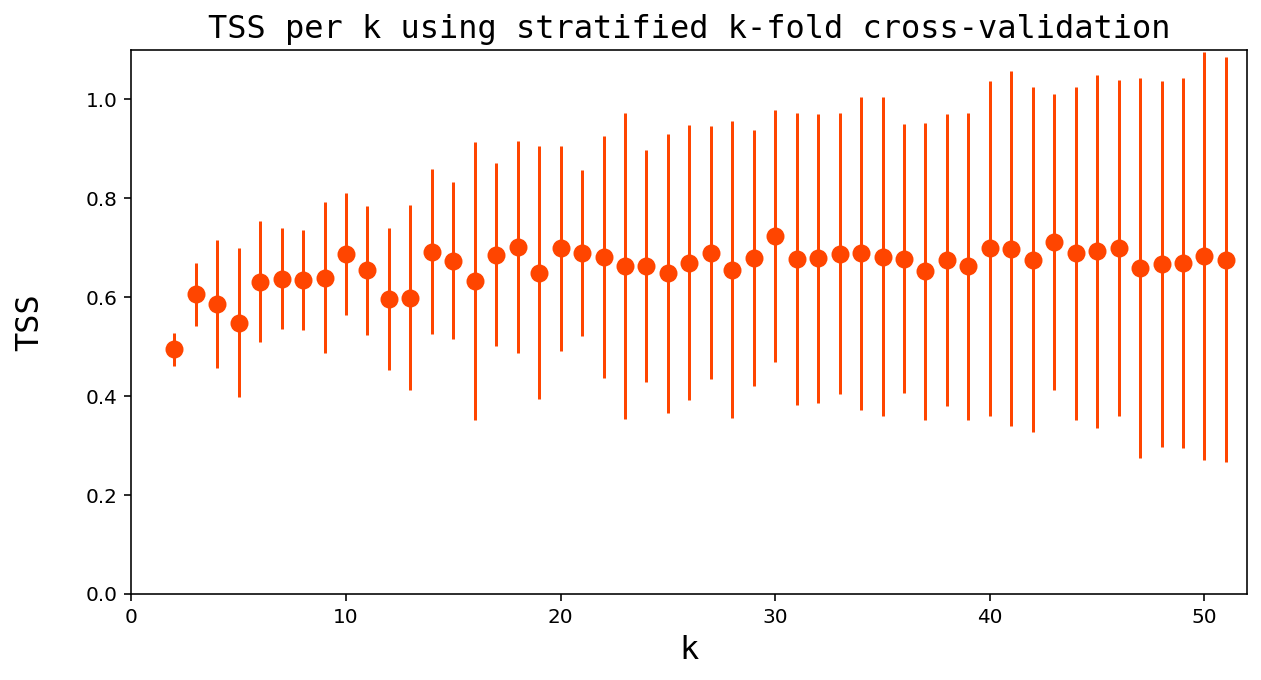

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))      # define the size of the figure
orangered = (1.0, 0.27, 0, 1.0)              # create an orange-red color
cornblue = (0.39, 0.58, 0.93, 1.0)           # create a cornflower-blue color

# define some style elements
marker_style_red = dict(linestyle='', markersize=8,
                        fillstyle='full', color=orangered, markeredgecolor=orangered)
marker_style_blue = dict(linestyle='', markersize=8,
                         fillstyle='full', color=cornblue, markeredgecolor=cornblue)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})

# ascribe the data to the axes
k = np.arange(50)+2
for i in range(50):
    if (array_of_avg_TSS[i] > array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],
                    yerr=array_of_std_TSS[i], linestyle='', color=orangered)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_red)
    if (array_of_avg_TSS[i] <= array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],
                    yerr=array_of_std_TSS[i], linestyle='', color=cornblue)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_blue)

# set plot limits
plt.xlim(xmax=52, xmin=0)
plt.ylim(ymax=1.1, ymin=0)

# label the axes and the plot
ax.set_xlabel('k', **text_style)
ax.set_ylabel('TSS', labelpad=20, **text_style)
plt.title(r'TSS per k using stratified k-fold cross-validation', **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)

High k-values result in a high variance. It is reasonable to use the stratified 10-fold cross-validation method to compute the TSS and will follow this recommendation. Therefore we report this score as our final result:

In [33]:
print("The TSS equals", array_of_avg_TSS[9],
      "plus or minus", array_of_std_TSS[9], ".")

The TSS equals 0.6547952047952048 plus or minus 0.13053813744235288 .
